In [0]:
def DNN(x_loc, y_loc):
  import pandas as pd
  import numpy as np
  import json
  import nltk
  import re
  import csv
  import matplotlib.pyplot as plt 
  import seaborn as sns
  from tqdm import tqdm
  from sklearn.feature_extraction.text import TfidfVectorizer
  from sklearn.model_selection import train_test_split
  import numpy as np
  from sklearn.preprocessing import MultiLabelBinarizer
  from keras.preprocessing import sequence
  from sklearn.model_selection import train_test_split
  import numpy as np
  import keras
  from keras.models import Sequential
  from keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional, Flatten
  from keras.layers import Embedding
  from keras.layers import Conv1D, GlobalMaxPooling1D
  # Binary Relevance
  from sklearn.multiclass import OneVsRestClassifier
  # Performance metric
  from sklearn.metrics import f1_score
  from sklearn.metrics import fbeta_score
  from sklearn.feature_extraction.text import TfidfVectorizer
 

  meta = pd.read_csv(x_loc, sep = '\t', header = None)
  # rename columns
  meta.columns = ["movie_id",1,"movie_name",3,4,5,6,7,"genre"]
 
  plots = []

  with open(y_loc, 'r') as f:
        reader = csv.reader(f, dialect='excel-tab') 
        for row in tqdm(reader):
              plots.append(row)
  movie_id = []
  plot = []

  # extract movie Ids and plot summaries
  for i in tqdm(plots):
    movie_id.append(i[0])
    plot.append(i[1])

  # create dataframe
  movies = pd.DataFrame({'movie_id': movie_id, 'plot': plot})
  # change datatype of 'movie_id'
  meta['movie_id'] = meta['movie_id'].astype(str)

  # merge meta with movies
  movies = pd.merge(movies, meta[['movie_id', 'movie_name', 'genre']], on = 'movie_id')

  movies['genre'][0]
  type(json.loads(movies['genre'][0]))
  json.loads(movies['genre'][0]).values()
  # an empty list
  genres = [] 

  # extract genres
  for i in movies['genre']: 
    genres.append(list(json.loads(i).values())) 

  # add to 'movies' dataframe  
  movies['genre_new'] = genres
  # remove samples with 0 genre tags
  movies_new = movies[~(movies['genre_new'].str.len() == 0)]
  movies_new.shape, movies.shape
  # get all genre tags in a list
  all_genres = sum(genres,[])
  # len(set(all_genres))
  all_genres = nltk.FreqDist(all_genres) 

  # create dataframe
  all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                                'Count': list(all_genres.values())})
  g = all_genres_df.nlargest(columns="Count", n = 50) 
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=g, x= "Count", y = "Genre", palette='Blues_d') 
  ax.set(ylabel = 'Count') 
  plt.show()
  # function for text cleaning 
  def clean_text(text):
      # remove backslash-apostrophe 
      text = re.sub("\'", "", text) 
      # remove everything except alphabets 
      text = re.sub("[^a-zA-Z]"," ",text) 
      # remove whitespaces 
      text = ' '.join(text.split()) 
      # convert text to lowercase 
      text = text.lower() 
      
      return text
  movies_new['clean_plot'] = movies_new['plot'].apply(lambda x: clean_text(x))
  def freq_words(x, terms = 30): 
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
    
    # selecting top 20 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 
    
    # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax1 = sns.barplot(data=d, x= "count", y = "word", palette="Blues_d") 
    ax1.set(ylabel = 'Word') 
    plt.show()
    
  nltk.download('stopwords')
  from nltk.corpus import stopwords
  stop_words = set(stopwords.words('english'))

  # function to remove stopwords
  def remove_stopwords(text):
      no_stopword_text = [w for w in text.split() if not w in stop_words]
      return ' '.join(no_stopword_text)

  movies_new['clean_plot'] = movies_new['clean_plot'].apply(lambda x: remove_stopwords(x))
  from nltk.stem import WordNetLemmatizer
  from nltk.stem.porter import PorterStemmer
  nltk.download('wordnet')
  lemmatizer=WordNetLemmatizer()
  def word_lemmatizer(text):
      lem_text = [lemmatizer.lemmatize(i) for i in text]
      return lem_text

  movies_new['clean_plot'] = movies_new['clean_plot'].apply(lambda x:word_lemmatizer(x))

  stemmer=PorterStemmer()
  def word_stemmer(text):
      stem_text = "".join([stemmer.stem(i) for i in text])
      return stem_text

  movies_new['clean_plot'] = movies_new['clean_plot'].apply(lambda x:word_stemmer(x))


  freq_words(movies_new['clean_plot'], 100)
  movies_new['clean_plot']


  multilabel_binarizer = MultiLabelBinarizer()
  multilabel_binarizer.fit(movies_new['genre_new'])

  # transform target variable
  y = multilabel_binarizer.transform(movies_new['genre_new'])

  tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=2605)
  # split dataset into training and validation set
  xtrain, xval, ytrain, yval = train_test_split(movies_new['clean_plot'],y, test_size=0.2, random_state=9)
  #create TF-IDF features
  xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
  xval_tfidf = tfidf_vectorizer.transform(xval)


  model = Sequential()
  model.add(Dense(5000, activation='relu', input_dim=2605))
  model.add(Dense(2500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1000, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(400, activation='relu'))
  model.add(Dense(363, activation='sigmoid'))
  a=model.summary()
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  history=model.fit(xtrain_tfidf, ytrain,epochs=50,batch_size=128,validation_split=0.1)
  ytrain_pred=model.predict(xtrain_tfidf)
  yval_pred=model.predict(xval_tfidf)
  score = model.evaluate(xval_tfidf, yval, batch_size=128)

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])

  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()
  # train_score = fbeta_score(ytrain, ytrain_pred, beta=0.5, average='micro')
  # test_score = fbeta_score(yval, yval_pred, beta=0.5, average='micro')
  # train_score, test_score
  return a, score

42303it [00:00, 57926.63it/s]
100%|██████████| 42303/42303 [00:00<00:00, 1344321.69it/s]


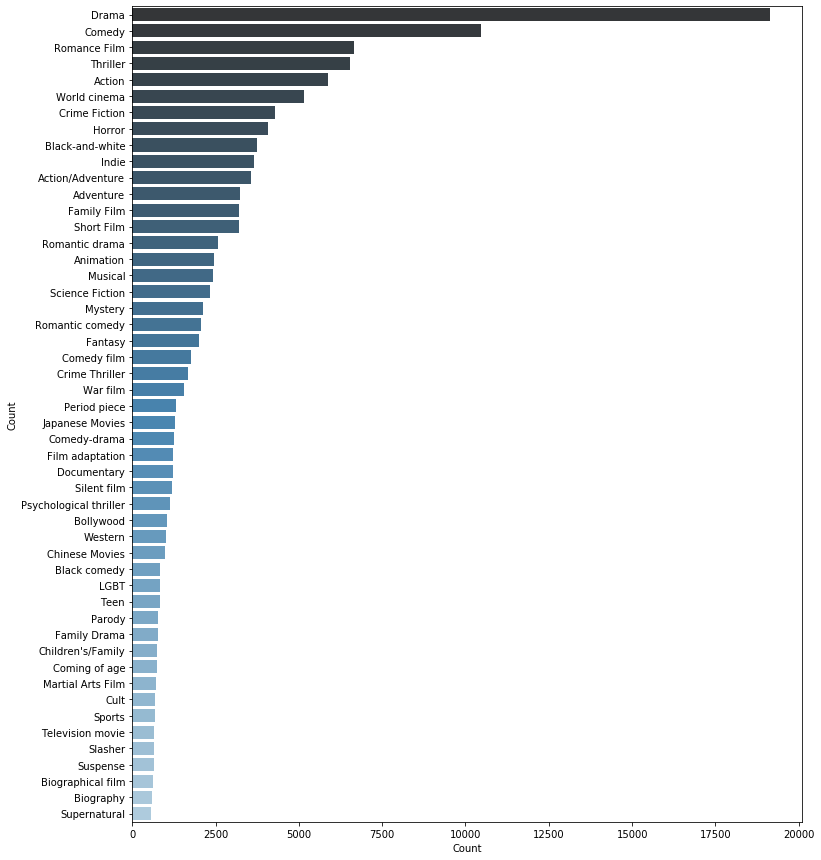

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


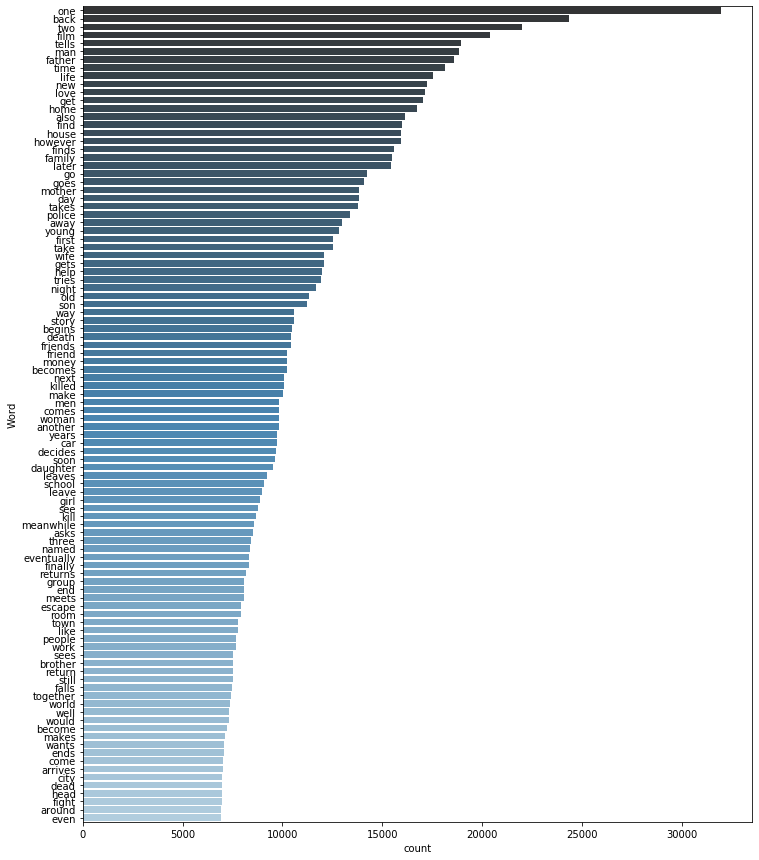

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2605, 32)          1069888   
_________________________________________________________________
flatten_1 (Flatten)          (None, 83360)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 5000)              416805000 
_________________________________________________________________
dense_21 (Dense)             (None, 2500)              12502500  
_________________________________________________________________
dropout_10 (Dropout)         (None, 2500)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 1000)              2501000   
_________________________________________________________________
dropout_11 (Dropout)         (None, 1000)             

In [0]:
DNN('movie.metadata.tsv','plot_summaries.txt')

In [0]:

def Conv1D(x_loc, y_loc):
  import pandas as pd
  import numpy as np
  import json
  import nltk
  import re
  import csv
  import matplotlib.pyplot as plt 
  import seaborn as sns
  from tqdm import tqdm
  from sklearn.feature_extraction.text import TfidfVectorizer
  from sklearn.model_selection import train_test_split
  import numpy as np
  from sklearn.preprocessing import MultiLabelBinarizer
  from keras.preprocessing import sequence
  from sklearn.model_selection import train_test_split
  import numpy as np
  import keras
  from keras.models import Sequential
  from keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional, Flatten
  from keras.layers import Embedding
  from keras.layers import Conv1D, GlobalMaxPooling1D
  # Binary Relevance
  from sklearn.multiclass import OneVsRestClassifier
  # Performance metric
  from sklearn.metrics import f1_score
  from sklearn.metrics import fbeta_score
  from sklearn.feature_extraction.text import TfidfVectorizer
 

  meta = pd.read_csv(x_loc, sep = '\t', header = None)
  # rename columns
  meta.columns = ["movie_id",1,"movie_name",3,4,5,6,7,"genre"]
 
  plots = []

  with open(y_loc, 'r') as f:
        reader = csv.reader(f, dialect='excel-tab') 
        for row in tqdm(reader):
              plots.append(row)
  movie_id = []
  plot = []

  # extract movie Ids and plot summaries
  for i in tqdm(plots):
    movie_id.append(i[0])
    plot.append(i[1])

  # create dataframe
  movies = pd.DataFrame({'movie_id': movie_id, 'plot': plot})
  # change datatype of 'movie_id'
  meta['movie_id'] = meta['movie_id'].astype(str)

  # merge meta with movies
  movies = pd.merge(movies, meta[['movie_id', 'movie_name', 'genre']], on = 'movie_id')

  movies['genre'][0]
  type(json.loads(movies['genre'][0]))
  json.loads(movies['genre'][0]).values()
  # an empty list
  genres = [] 

  # extract genres
  for i in movies['genre']: 
    genres.append(list(json.loads(i).values())) 

  # add to 'movies' dataframe  
  movies['genre_new'] = genres
  # remove samples with 0 genre tags
  movies_new = movies[~(movies['genre_new'].str.len() == 0)]
  movies_new.shape, movies.shape
  # get all genre tags in a list
  all_genres = sum(genres,[])
  # len(set(all_genres))
  all_genres = nltk.FreqDist(all_genres) 

  # create dataframe
  all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                                'Count': list(all_genres.values())})
  g = all_genres_df.nlargest(columns="Count", n = 50) 
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=g, x= "Count", y = "Genre", palette='Blues_d') 
  ax.set(ylabel = 'Count') 
  plt.show()
  # function for text cleaning 
  def clean_text(text):
      # remove backslash-apostrophe 
      text = re.sub("\'", "", text) 
      # remove everything except alphabets 
      text = re.sub("[^a-zA-Z]"," ",text) 
      # remove whitespaces 
      text = ' '.join(text.split()) 
      # convert text to lowercase 
      text = text.lower() 
      
      return text
  movies_new['clean_plot'] = movies_new['plot'].apply(lambda x: clean_text(x))
  def freq_words(x, terms = 30): 
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
    
    # selecting top 20 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 
    
    # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax1 = sns.barplot(data=d, x= "count", y = "word", palette="Blues_d") 
    ax1.set(ylabel = 'Word') 
    plt.show()
    
  nltk.download('stopwords')
  from nltk.corpus import stopwords
  stop_words = set(stopwords.words('english'))

  # function to remove stopwords
  def remove_stopwords(text):
      no_stopword_text = [w for w in text.split() if not w in stop_words]
      return ' '.join(no_stopword_text)

  movies_new['clean_plot'] = movies_new['clean_plot'].apply(lambda x: remove_stopwords(x))
  from nltk.stem import WordNetLemmatizer
  from nltk.stem.porter import PorterStemmer
  nltk.download('wordnet')
  lemmatizer=WordNetLemmatizer()
  def word_lemmatizer(text):
      lem_text = [lemmatizer.lemmatize(i) for i in text]
      return lem_text

  movies_new['clean_plot'] = movies_new['clean_plot'].apply(lambda x:word_lemmatizer(x))

  stemmer=PorterStemmer()
  def word_stemmer(text):
      stem_text = "".join([stemmer.stem(i) for i in text])
      return stem_text

  movies_new['clean_plot'] = movies_new['clean_plot'].apply(lambda x:word_stemmer(x))


  freq_words(movies_new['clean_plot'], 100)
  movies_new['clean_plot']


  multilabel_binarizer = MultiLabelBinarizer()
  multilabel_binarizer.fit(movies_new['genre_new'])

  # transform target variable
  y = multilabel_binarizer.transform(movies_new['genre_new'])

  tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=2605)
  # split dataset into training and validation set
  xtrain, xval, ytrain, yval = train_test_split(movies_new['clean_plot'],y, test_size=0.2, random_state=9)
  #create TF-IDF features
  xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
  xval_tfidf = tfidf_vectorizer.transform(xval)


  model_c = Sequential()
  model_c.add(Embedding(33434,32,input_length=2605))

  # we add a Convolution1D, which will learn filters
  # word group filters of size filter_length:
  model_c.add(Conv1D(filters=64,kernel_size=3,activation='relu'))
  # we use max pooling:
  model_c.add(GlobalMaxPooling1D())

  model_c.add(Dense(5000))
  model_c.add(Dropout(0.5))
  model_c.add(Activation('relu'))

  model_c.add(Dense(2500))
  model_c.add(Dropout(0.5))
  model_c.add(Activation('relu'))

  model_c.add(Dense(1000))
  model_c.add(Dropout(0.5))
  model_c.add(Activation('relu'))

  model_c.add(Dense(500))
  model_c.add(Dropout(0.5))
  model_c.add(Activation('relu'))

  model_c.add(Dense(400))
  model_c.add(Activation('relu'))


  # We project onto a single unit output layer, and squash it with a sigmoid:
  model_c.add(Dense(363))
  model_c.add(Activation('sigmoid'))

  a=model_c.summary()



  model_c.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  history=model_c.fit(xtrain_tfidf, ytrain,
            batch_size=1028,
            epochs=30,  validation_split=0.1)
  score_c = model_c.evaluate(xval_tfidf, yval, batch_size=512)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])

  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()
  # train_score = fbeta_score(ytrain, ytrain_pred, beta=0.5, average='micro')
  # test_score = fbeta_score(yval, yval_pred, beta=0.5, average='micro')
  # train_score, test_score
  return a, score_c

Using TensorFlow backend.


42303it [00:00, 45187.52it/s]
100%|██████████| 42303/42303 [00:00<00:00, 1348111.10it/s]


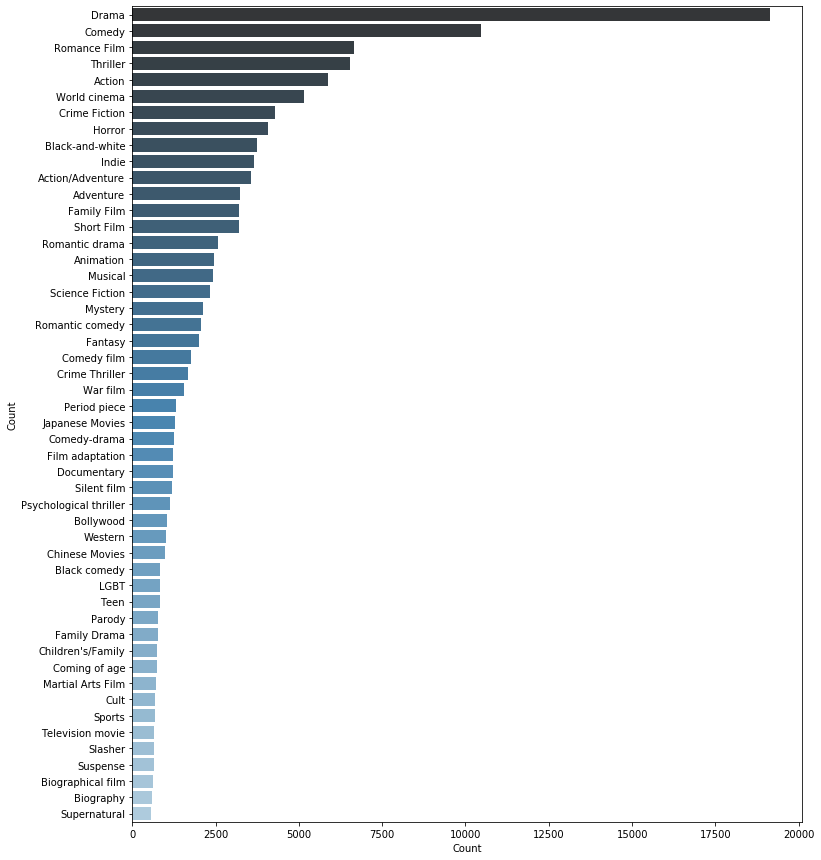

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


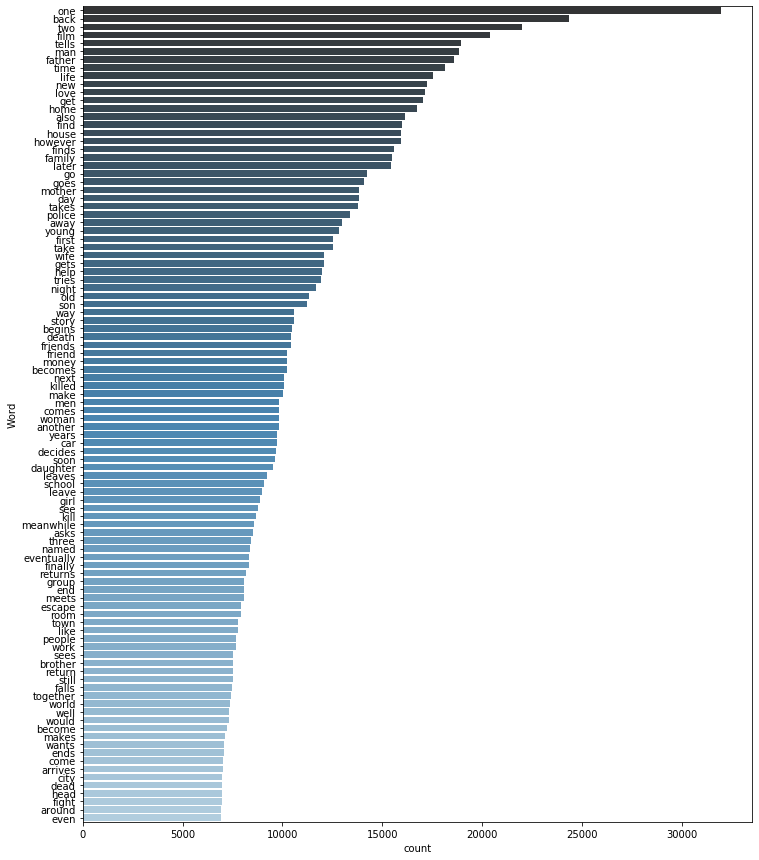





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2605, 32)          1069888   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2603, 64)          6208      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5000)              325000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5000)              0         
_________________________________________________________________
activation_1 (Activation)    (None, 5000)              0         
_

NameError: ignored

In [0]:
Conv1D('movie.metadata.tsv','plot_summaries.txt')

In [0]:
def LSTM(x_loc, y_loc):

  import pandas as pd
  import numpy as np
  import json
  import nltk
  import re
  import csv
  import matplotlib.pyplot as plt 
  import seaborn as sns
  from tqdm import tqdm
  from sklearn.feature_extraction.text import TfidfVectorizer
  from sklearn.model_selection import train_test_split
  import numpy as np
  from sklearn.preprocessing import MultiLabelBinarizer
  from keras.preprocessing import sequence
  from sklearn.model_selection import train_test_split
  import numpy as np
  import keras
  from keras.models import Sequential
  from keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional, Flatten
  from keras.layers import Embedding
  from keras.layers import Conv1D, GlobalMaxPooling1D
  # Binary Relevance
  from sklearn.multiclass import OneVsRestClassifier
  # Performance metric
  from sklearn.metrics import f1_score
  from sklearn.metrics import fbeta_score
  from sklearn.feature_extraction.text import TfidfVectorizer
 

  meta = pd.read_csv(x_loc, sep = '\t', header = None)
  # rename columns
  meta.columns = ["movie_id",1,"movie_name",3,4,5,6,7,"genre"]
 
  plots = []

  with open(y_loc, 'r') as f:
        reader = csv.reader(f, dialect='excel-tab') 
        for row in tqdm(reader):
              plots.append(row)
  movie_id = []
  plot = []

  # extract movie Ids and plot summaries
  for i in tqdm(plots):
    movie_id.append(i[0])
    plot.append(i[1])

  # create dataframe
  movies = pd.DataFrame({'movie_id': movie_id, 'plot': plot})
  # change datatype of 'movie_id'
  meta['movie_id'] = meta['movie_id'].astype(str)

  # merge meta with movies
  movies = pd.merge(movies, meta[['movie_id', 'movie_name', 'genre']], on = 'movie_id')

  movies['genre'][0]
  type(json.loads(movies['genre'][0]))
  json.loads(movies['genre'][0]).values()
  # an empty list
  genres = [] 

  # extract genres
  for i in movies['genre']: 
    genres.append(list(json.loads(i).values())) 

  # add to 'movies' dataframe  
  movies['genre_new'] = genres
  # remove samples with 0 genre tags
  movies_new = movies[~(movies['genre_new'].str.len() == 0)]
  movies_new.shape, movies.shape
  # get all genre tags in a list
  all_genres = sum(genres,[])
  # len(set(all_genres))
  all_genres = nltk.FreqDist(all_genres) 

  # create dataframe
  all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                                'Count': list(all_genres.values())})
  g = all_genres_df.nlargest(columns="Count", n = 50) 
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=g, x= "Count", y = "Genre", palette='Blues_d') 
  ax.set(ylabel = 'Count') 
  plt.show()
  # function for text cleaning 
  def clean_text(text):
      # remove backslash-apostrophe 
      text = re.sub("\'", "", text) 
      # remove everything except alphabets 
      text = re.sub("[^a-zA-Z]"," ",text) 
      # remove whitespaces 
      text = ' '.join(text.split()) 
      # convert text to lowercase 
      text = text.lower() 
      
      return text
  movies_new['clean_plot'] = movies_new['plot'].apply(lambda x: clean_text(x))
  def freq_words(x, terms = 30): 
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
    
    # selecting top 20 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 
    
    # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax1 = sns.barplot(data=d, x= "count", y = "word", palette="Blues_d") 
    ax1.set(ylabel = 'Word') 
    plt.show()
    
  nltk.download('stopwords')
  from nltk.corpus import stopwords
  stop_words = set(stopwords.words('english'))

  # function to remove stopwords
  def remove_stopwords(text):
      no_stopword_text = [w for w in text.split() if not w in stop_words]
      return ' '.join(no_stopword_text)

  movies_new['clean_plot'] = movies_new['clean_plot'].apply(lambda x: remove_stopwords(x))
  from nltk.stem import WordNetLemmatizer
  from nltk.stem.porter import PorterStemmer
  nltk.download('wordnet')
  lemmatizer=WordNetLemmatizer()
  def word_lemmatizer(text):
      lem_text = [lemmatizer.lemmatize(i) for i in text]
      return lem_text

  movies_new['clean_plot'] = movies_new['clean_plot'].apply(lambda x:word_lemmatizer(x))

  stemmer=PorterStemmer()
  def word_stemmer(text):
      stem_text = "".join([stemmer.stem(i) for i in text])
      return stem_text

  movies_new['clean_plot'] = movies_new['clean_plot'].apply(lambda x:word_stemmer(x))


  freq_words(movies_new['clean_plot'], 100)
  movies_new['clean_plot']


  multilabel_binarizer = MultiLabelBinarizer()
  multilabel_binarizer.fit(movies_new['genre_new'])

  # transform target variable
  y = multilabel_binarizer.transform(movies_new['genre_new'])

  tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=2605)
  # split dataset into training and validation set
  xtrain, xval, ytrain, yval = train_test_split(movies_new['clean_plot'],y, test_size=0.2, random_state=9)
  #create TF-IDF features
  xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
  xval_tfidf = tfidf_vectorizer.transform(xval)
    
  from keras.preprocessing import sequence
  import keras
  from keras.models import Sequential
  from keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional, Flatten
  from keras.layers import Embedding
  from keras.layers import Conv1D, GlobalMaxPooling1D
  # Binary Relevance
  from sklearn.multiclass import OneVsRestClassifier
  # Performance metric
  from sklearn.metrics import f1_score
  from sklearn.metrics import fbeta_score
  import matplotlib.pyplot as plt


  model_l = Sequential()
  model_l.add(Embedding(33434, 32, input_length=2605))
  model_l.add(LSTM(units=32)) 
  model_l.add(Dense(363, activation="sigmoid"))  
  

  a=model_l.summary() 
  model_l.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  history=model_l.fit(xtrain_tfidf, ytrain, batch_size=1028,epochs=5, validation_split=.1)
  score_l = model_l.evaluate(xval_tfidf, yval, batch_size=512)
  
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])

  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()
  # train_score = fbeta_score(ytrain, ytrain_pred, beta=0.5, average='micro')
  # test_score = fbeta_score(yval, yval_pred, beta=0.5, average='micro')
  # train_score, test_score
  return a, score_l

Using TensorFlow backend.


42303it [00:01, 38800.22it/s]
100%|██████████| 42303/42303 [00:00<00:00, 1367383.19it/s]


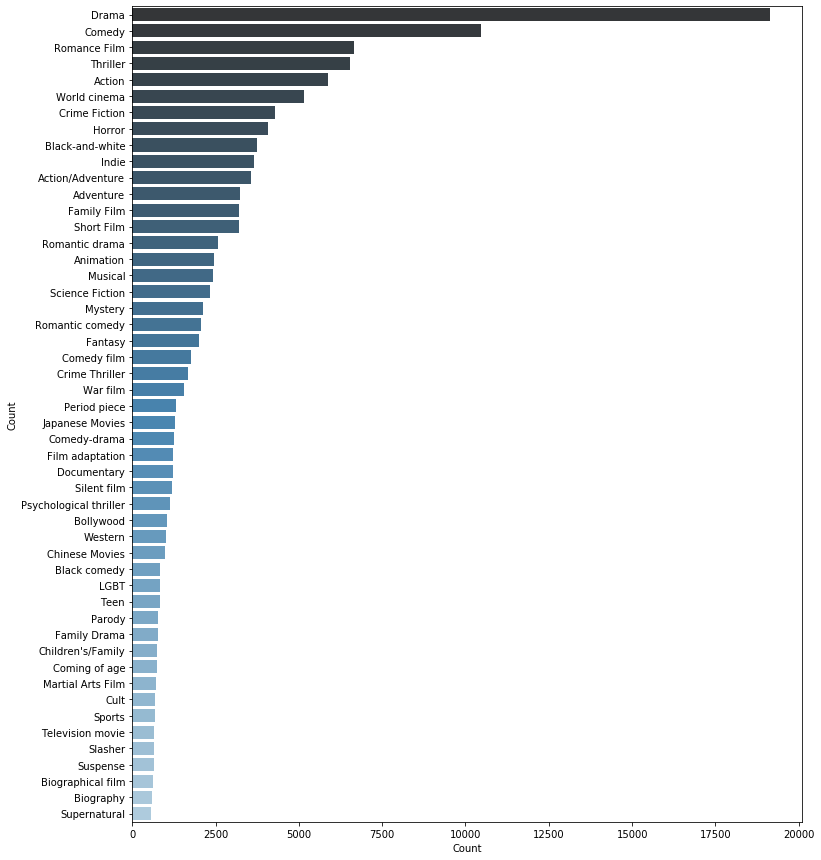

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


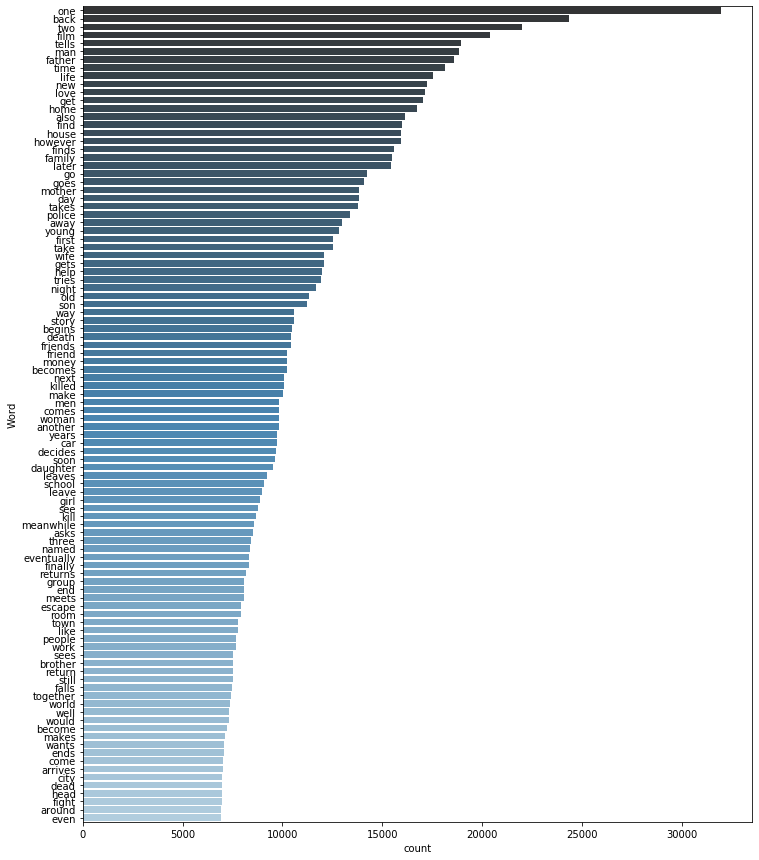




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2605, 32)          1069888   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 363)               11979     
Total params: 1,090,187
Trainable params: 1,090,187
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 30090 samples, validate on 3344 samples
Epoch 1/5





30090/30090 [==============================] - 147s 5ms/step - loss: 0.6583 - acc: 0.8754 - val_loss: 0.5133 - val_acc: 0.9873
Epoch 2/5
30090/30090 [==============================] - 143s 5ms/step - loss: 0.

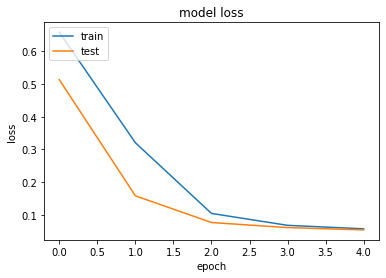

(None, [0.05387079943194745, 0.9900201681713009])

In [0]:
LSTM('movie.metadata.tsv','plot_summaries.txt')